* test in batches
* bidirectional lstm can't help here
* wordtoix start from 1 not 0

In [1]:
import os
import matplotlib.pyplot as plt
import sys
import pickle
from keras.utils import plot_model
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [3]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features


#### Reading the captions

In [4]:
doc = load_doc("data/Flickr8k.token.txt")

In [5]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

next(iter(descriptions)),descriptions[next(iter(descriptions))]

('3608752424_01a1cfd8a6',
 ['a couple of dogs running through the water with trees in the background',
  'Two dogs are running through a small pond',
  'Two dogs play in a river , one is making a splash .',
  'Two dogs run through the water near trees .',
  'Two dogs standing in a lake .'])

#### Cleaning the data

In [6]:
def clean_data(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [7]:
descriptions_clean = clean_data(descriptions)

#### Creating a vocabluray of all words in image captions

In [8]:
def create_vocab(descriptions):
    vocabulary = set()
    for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
    print('Vocabulary Size: %d' % len(vocabulary))
    return vocabulary

In [9]:
vocab = create_vocab(descriptions_clean)

Vocabulary Size: 8763


too many words that may not be repeated in preds !

#### Adding start and end token to the sequence of words

In [10]:
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = '<startseq> '+descriptions[key][i]+ ' <endseq>'
    return descriptions

In [11]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)

In [12]:
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> couple of dogs running through the water with trees in the background <endseq>',
 '<startseq> two dogs are running through small pond <endseq>',
 '<startseq> two dogs play in river one is making splash <endseq>',
 '<startseq> two dogs run through the water near trees <endseq>',
 '<startseq> two dogs standing in lake <endseq>']

#### Loading train captions

In [13]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [14]:
train_imgs_addr = 'data/Flickr_8k.trainImages.txt'
test_imgs_addr = 'data/Flickr_8k.testImages.txt'
dev_imgs_addr = 'data/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [15]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

#### reoccuring vocab

In [16]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    print('Vocab Size %d ' % len(vocab))
    return vocab

In [17]:
train_reoc_desc = create_reoccurring_vocab(train_descriptions, word_count_threshold = 10)
# test_reoc_desc = create_reoccurring_vocab(test_descriptions, word_count_threshold = 10)
# dev_reoc_desc = create_reoccurring_vocab(dev_descriptions, word_count_threshold = 10)

Vocab Size 1651 


In [18]:
vocab_size = len(train_reoc_desc) +1
print('vocab_size :', vocab_size)

vocab_size : 1652


In [19]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

ix = 1
for w in train_reoc_desc:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

#### finding the maximum sequence size to use in RNN

In [20]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 34


#### feature extractor model Xception

In [21]:
# xception = Xception()
# extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
# print(extractor.summary())

In [22]:
# def extract_features(description, model, inpute_size = (229,229)):
#     directory = 'data\\Flicker8k_Dataset'
#     features = {}
#     i = 0
#     for name in description:
#         progressBar(value=i,endvalue=len(descriptions))
#         i +=1
#         filename =os.path.join(directory, name+'.jpg')
#         image = load_img(filename, target_size=inpute_size)
#         image = img_to_array(image)
#         image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#         image = preprocess_input(image)
#         feature = model.predict(image, verbose=0)
#         image_id = name.split('.')[0]
#         features[image_id] = feature.reshape(2048)
#     return features

In [23]:
# train_features = extract_features(train_descriptions, extractor)
# test_features = extract_features(test_descriptions, extractor)
# dev_features = extract_features(dev_descriptions, extractor)

# pickle.dump(train_features, open('train_features.pkl', 'wb'))
# pickle.dump(test_features, open('test_features.pkl', 'wb'))
# pickle.dump(dev_features, open('dev_features.pkl', 'wb'))
with open('dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('test_features.pkl','rb') as f:
    test_features= pickle.load(f)


#### Data Genarator

In [24]:
# out puts a batch of captions-pictures
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                # Each step of the following for loop selects one word
                # from the caption, consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#### Word Emeddings glove 

I used wikipedia corpus that includes 400k words in 200d 

download from here: https://github.com/stanfordnlp/GloVe

In [25]:
def make_embedding_layer(vocab_size, embedding_dim=200, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = 'glove'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get 200-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [26]:
embedding_layer = make_embedding_layer(vocab_size, glove=True)
# in order to make model faster, I load embd outside the make_model

#### Constructing the model

In [27]:
def make_model(vocab_size, embedding_layer,dout= 0.5, max_length= 34, feature_size= 2048, units= 256):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe = Dense(units, activation='relu')(features) # because i have used bidirectional LSTM, the number of units should
                                                   # become double here in order for the add function to work
    X_fe = Dropout(dout)(X_fe)

    seq = Input(shape=(max_length,))
    X_seq = embedding_layer(seq)
    X_seq = LSTM(units, return_sequences=True)(X_seq)
    X_seq = Dropout(dout)(X_seq)
    X_seq = LSTM(units, return_sequences=False)(X_seq)

    feature_seq = add([X_fe, X_seq])
    decoder = Dense(units, activation='relu')(feature_seq)
    decoder = Dropout(dout-0.2)(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs=outputs)
    return model

In [28]:
model = make_model(vocab_size, embedding_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 34, 256)      467968      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (D

In [29]:
# plot_model(model, to_file='model2.png', show_shapes=True)

In [30]:
# optim = optimizers.Adam(decay=1e-7)
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

#### Training the model

In [31]:
history={'acc':[],'val_acc':[], 'loss':[], 'loss_val':[],'belus':[]}

In [32]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, max_length=34, inference= False):
    # seed the generation process
    in_text = '<startseq>'
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == '<endseq>':
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == 34:
            in_text = in_text[1:] #if endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [33]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, max_len = 34, log =False):
    start = [wordtoix['<startseq>']]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
#             print('='*10)
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
#                 print(next_cap)
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
#         print(start_word)
#         print('='*10)

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != '<endseq>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [109]:
def evaluate_model(model, descriptions, photos_fe, max_length=34, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [36]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

In [37]:
epochs = 200
number_pics_per_bath = 64
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    print('Epoch ',i)
    # create the data generator
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    
    history['acc'].append(h.history['acc'])
    history['loss'].append(h.history['loss'])
    
    # save model every 10 epochs
    if i % 10 == 10:
        model.save('weights/model_2_' + str(i) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, max_length, K_beams=1)    
        history['belus'].append(belus)

    print('\n','='*80)

Epoch  0
Epoch 1/1
93/93 [==============================] - 38s 407ms/step - loss: 5.3507 - acc: 0.1319

Epoch  1
Epoch 1/1
93/93 [==============================] - 36s 388ms/step - loss: 4.3619 - acc: 0.2124

Epoch  2
Epoch 1/1
93/93 [==============================] - 36s 389ms/step - loss: 3.9396 - acc: 0.2470

Epoch  3
Epoch 1/1
93/93 [==============================] - 37s 394ms/step - loss: 3.7237 - acc: 0.2646

Epoch  4
Epoch 1/1
93/93 [==============================] - 37s 396ms/step - loss: 3.5778 - acc: 0.2790

Epoch  5
Epoch 1/1
93/93 [==============================] - 37s 398ms/step - loss: 3.4680 - acc: 0.2894

Epoch  6
Epoch 1/1
93/93 [==============================] - 37s 397ms/step - loss: 3.3826 - acc: 0.2983

Epoch  7
Epoch 1/1
93/93 [==============================] - 37s 398ms/step - loss: 3.3091 - acc: 0.3063

Epoch  8
Epoch 1/1
93/93 [==============================] - 37s 397ms/step - loss: 3.2525 - acc: 0.3111

Epoch  9
Epoch 1/1
93/93 [=============================

93/93 [==============================] - 37s 398ms/step - loss: 2.5516 - acc: 0.3911

Epoch  45
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.5412 - acc: 0.3935

Epoch  46
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.5327 - acc: 0.3937

Epoch  47
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.5294 - acc: 0.3941

Epoch  48
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.5149 - acc: 0.3965

Epoch  49
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.5085 - acc: 0.3968

Epoch  50
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.5025 - acc: 0.3979

Epoch  51
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.4938 - acc: 0.3991

Epoch  52
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.4825 - acc: 0.3997

Epoch  53
Epoch 1/1
93/93 [==============================] - 37s 4

93/93 [==============================] - 37s 399ms/step - loss: 2.2849 - acc: 0.4293

Epoch  89
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2793 - acc: 0.4308

Epoch  90
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2791 - acc: 0.4304

Epoch  91
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2751 - acc: 0.4314

Epoch  92
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2657 - acc: 0.4320

Epoch  93
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.2636 - acc: 0.4326

Epoch  94
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2591 - acc: 0.4329

Epoch  95
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.2542 - acc: 0.4337

Epoch  96
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.2532 - acc: 0.4340

Epoch  97
Epoch 1/1
93/93 [==============================] - 37s 4

93/93 [==============================] - 37s 400ms/step - loss: 2.1568 - acc: 0.4493

Epoch  132
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1482 - acc: 0.4515

Epoch  133
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1527 - acc: 0.4500

Epoch  134
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.1427 - acc: 0.4531

Epoch  135
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.1408 - acc: 0.4525

Epoch  136
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1378 - acc: 0.4533

Epoch  137
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1363 - acc: 0.4529

Epoch  138
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1314 - acc: 0.4540

Epoch  139
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.1284 - acc: 0.4542

Epoch  140
Epoch 1/1
93/93 [==============================

93/93 [==============================] - 37s 400ms/step - loss: 2.0616 - acc: 0.4668

Epoch  175
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.0655 - acc: 0.4659

Epoch  176
Epoch 1/1
93/93 [==============================] - 37s 401ms/step - loss: 2.0645 - acc: 0.4661

Epoch  177
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.0600 - acc: 0.4670

Epoch  178
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.0562 - acc: 0.4693

Epoch  179
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.0554 - acc: 0.4678

Epoch  180
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.0542 - acc: 0.4679

Epoch  181
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 2.0542 - acc: 0.4676

Epoch  182
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 2.0496 - acc: 0.4693

Epoch  183
Epoch 1/1
93/93 [==============================

#### Test the model

In [ ]:
from keras.models import load_model
new_model = load_model('weights/model_2_270.h5')

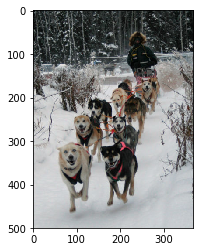

Greedy: two dogs are pulling sled through the snow


In [49]:
pic = list(test_features.keys())[2]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))

In [51]:
beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False)

'dogs pull sled in the snow'

In [53]:
epochs = 200
number_pics_per_bath = 64
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    print('Epoch ',i+200)
    # create the data generator
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    
    history['acc'].append(h.history['acc'])
    history['loss'].append(h.history['loss'])
    
    # save model every 10 epochs
    if i % 10 == 0:
        model.save('weights/model_2_' + str(i+200) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, max_length, K_beams=1)    
        history['belus'].append(belus)

    print('\n','='*80)

Epoch  200
Epoch 1/1
93/93 [==============================] - 36s 389ms/step - loss: 2.0348 - acc: 0.4713
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.540722
BLEU-2: 0.307887
BLEU-3: 0.223256
BLEU-4: 0.115275

Epoch  201
Epoch 1/1
93/93 [==============================] - 36s 388ms/step - loss: 2.0192 - acc: 0.4747

Epoch  202
Epoch 1/1
93/93 [==============================] - 36s 390ms/step - loss: 2.0174 - acc: 0.4745

Epoch  203
Epoch 1/1
93/93 [==============================] - 36s 391ms/step - loss: 2.0145 - acc: 0.4766

Epoch  204
Epoch 1/1
93/93 [==============================] - 37s 395ms/step - loss: 2.0125 - acc: 0.4752

Epoch  205
Epoch 1/1
93/93 [==============================] - 37s 396ms/step - loss: 2.0107 - acc: 0.4757

Epoch  206
Epoch 1/1
93/93 [==============================] - 37s 396ms/step - loss: 2.0119 - acc: 0.4763

Epoch  207
Epoch 1/1
93/93 [==============================] - 37s 396ms/step - loss: 2.0118 - acc: 0.4776

Epoch  208
Epoch 1/1
93/

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.555190
BLEU-2: 0.316131
BLEU-3: 0.227044
BLEU-4: 0.114013

Epoch  241
Epoch 1/1
93/93 [==============================] - 36s 389ms/step - loss: 1.9690 - acc: 0.4845

Epoch  242
Epoch 1/1
93/93 [==============================] - 36s 391ms/step - loss: 1.9688 - acc: 0.4840

Epoch  243
Epoch 1/1
93/93 [==============================] - 37s 397ms/step - loss: 1.9680 - acc: 0.4847

Epoch  244
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 1.9668 - acc: 0.4849

Epoch  245
Epoch 1/1
93/93 [==============================] - 37s 398ms/step - loss: 1.9661 - acc: 0.4853

Epoch  246
Epoch 1/1
93/93 [==============================] - 37s 400ms/step - loss: 1.9684 - acc: 0.4845

Epoch  247
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 1.9690 - acc: 0.4842

Epoch  248
Epoch 1/1
93/93 [==============================] - 37s 399ms/step - loss: 1.9612 - acc: 0.4866

Epoch  249
Epoch 1/1
93

KeyboardInterrupt: 

In [61]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=5)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.431952
BLEU-2: 0.266745
BLEU-3: 0.195606
BLEU-4: 0.098369


[0.43195222390334526,
 0.26674459058140104,
 0.19560587293431417,
 0.09836893395863869]

In [62]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=3)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.443121
BLEU-2: 0.273559
BLEU-3: 0.200355
BLEU-4: 0.100139


[0.44312101389376324,
 0.2735585406468653,
 0.20035535922546233,
 0.10013893306955632]

In [63]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.563415
BLEU-2: 0.334128
BLEU-3: 0.244885
BLEU-4: 0.127020


[0.5634150979273627,
 0.33412751004708896,
 0.24488458908425242,
 0.12701953930128124]

In [110]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=3,log=True)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.438949
BLEU-2: 0.273950
BLEU-3: 0.203961
BLEU-4: 0.105424


[0.4389494147770438,
 0.2739497911319962,
 0.20396128465808236,
 0.10542350067044849]

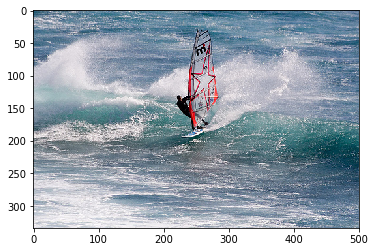

Greedy: man in red wetsuit is surfing on wave
Beam K= 3: man is surfing in the ocean
Beam K= 5: man is surfing in the ocean


In [68]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))

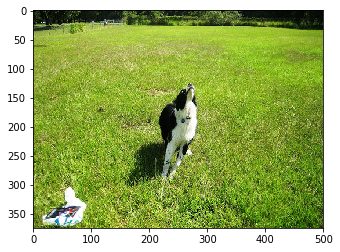

Greedy: dog is running through field
Beam K= 3: brown and white dog is running through the grass
Beam K= 5: brown and white dog is running through the grass


In [76]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))

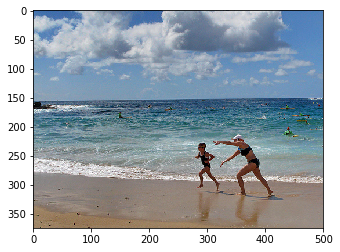

Greedy: two people are walking on beach
Beam K= 3: three people are walking on beach
Beam K= 5: group of people stand in the sand


In [77]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))

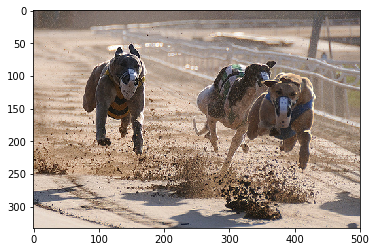

Greedy: two dogs are running on the grass
Beam K= 3: two dogs running in the dirt
Beam K= 5: group of muzzled greyhound dogs are running


In [81]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))

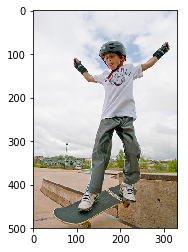

Greedy: man in red shirt is standing on the edge of the road
Beam K= 3: man in red shirt is standing in front of playground equipment
Beam K= 5: man in red shirt is doing trick on his skateboard


In [94]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))

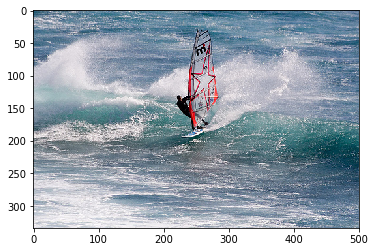

Greedy: man in red wetsuit is surfing on wave
Beam K= 3: man is surfing in the ocean
Beam K= 5: man is surfing in the ocean
Beam log K= 3: surfer is riding wave on breaking wave
Beam log K= 5: man is surfing in the ocean


In [96]:
pic = list(test_features.keys())[1]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

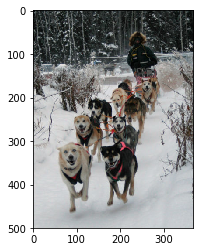

Greedy: man in red jacket is standing in front of an orange tent
Beam K= 3: two dogs are pulling sled through the snow
Beam K= 5: the dogs are racing in the race
Beam log K= 3: three dogs are pulling sled through the snow
Beam log K= 5: three dogs are pulling sled through the snow


In [97]:
pic = list(test_features.keys())[2]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

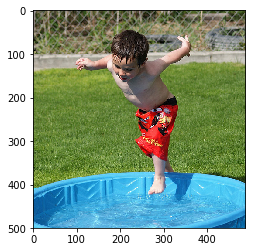

Greedy: little boy in blue shirt is running through the grass
Beam K= 3: little boy in blue shorts is running through water
Beam K= 5: little boy in blue shorts is running through water
Beam log K= 3: little boy in blue shorts is running through water
Beam log K= 5: little boy in blue shorts is running through water


In [106]:
pic = list(test_features.keys())[560]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('data/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))